### TensorFlow basics

In [2]:
import tensorflow as tf
import numpy as np
import time

/usr/local/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


---
The fundamental objects we have in tensorflow are **graphs** and **sessions**. The default graph would be used if no graph is specified explicitly. The `InteractiveSession` allows less typing (notice that we don't need `session = sess` or `sess.run`)

In [3]:
sess = tf.InteractiveSession()
k = tf.Variable(90)
l = tf.Variable(9)
tf.global_variables_initializer().run()
print(tf.add(k, l).eval())
sess.close()

99


### MNIST dataset

A very popular toyset to demonstrate neural network is the mnist dataset. The dataset and the description can be found at <a href=http://yann.lecun.com/exdb/mnist/>Yann LeCun's website</a>. The package tensorflow also provide a function to load the dataset:

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [5]:
dir(mnist)

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_asdict',
 '_fields',
 '_make',
 '_replace',
 '_source',
 'count',
 'index',
 'test',
 'train',
 'validation']

In [6]:
print('The size of the training input:', mnist.train.images.shape)
print('The size of the training label:', mnist.train.labels.shape)

The size of the training input: (55000, 784)
The size of the training label: (55000, 10)


The validation and the test sets can be loaded in the same way.

Below we demo a convenient way to save your data:

In [7]:
from six.moves import cPickle as pickle

In [8]:
set_filename = './saved_data.pkl'
to_be_saved = {'images': mnist.train.images,
               'labels': mnist.train.labels}

with open(set_filename, 'wb') as f:
    pickle.dump(to_be_saved, f, pickle.HIGHEST_PROTOCOL)

In [9]:
pickle_file = './saved_data.pkl'

with open(pickle_file, 'rb') as f:
    loaded_data = pickle.load(f)

images = loaded_data['images']
labels = loaded_data['labels']

### A simple logistic regression

Let's start with a **logistic regression** on a simple dataset. Below we visualize this toy dataset:

x_train shape :  (400, 1)
y_train shape :  (400, 1)


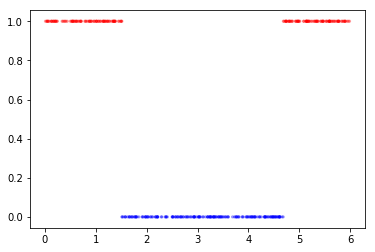

In [10]:
x_train = np.array(sorted(np.random.rand(400)*6)).reshape(-1, 1)
print('x_train shape : ', x_train.shape)
y_train = np.array([1]*100+[0]*200 + [1]*100).reshape(-1,1)
print('y_train shape : ', y_train.shape)

import matplotlib.pyplot as plt
%matplotlib inline
color  = list(map(lambda x: 'b' if x==0 else 'r', y_train))
plt.scatter(x_train, y_train, s=5, alpha=0.3, color= color)

Let's inspect the result from `sklearn`:

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


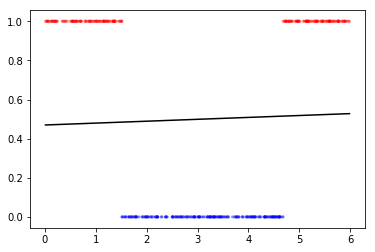

In [11]:
from sklearn import linear_model
logit = linear_model.LogisticRegression(C = 1e8)
logit.fit(x_train, y_train)
probability = logit.predict_proba(x_train)

plt.scatter(x_train, y_train, s=5, alpha=0.3, color= color)
plt.plot(x_train, probability[:,0], c='k')

---

Below we implement logistic regression with tensorflow. Here is the formula how logistic regression generates probability

<img src = https://s3-us-west-2.amazonaws.com/nycdatasciecneipynb/logistic.png height=200 width = 300>




Below pay attention to 

- the TensorFlow data types: **`constant`** and **`Variable`**.
- the **`forward propagation`** and the **`backpropagation`**.

In [12]:
sess = tf.InteractiveSession()

x = tf.constant(x_train, dtype=tf.float32)
y = tf.constant(y_train, dtype=tf.float32)
w = tf.Variable(tf.truncated_normal([1,1], stddev=0.1))
b = tf.Variable(tf.constant(0.1, shape=[1,1]))


y_lin = tf.add(tf.matmul(x, w), b)
log_likelihood = tf.reduce_mean(y_lin*y - tf.log(1+tf.exp(y_lin)), 0)
loss = -1*log_likelihood ### We may simply use the Python operators as well
train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss) # 0.1 is the learning rate

steps = 200
tf.global_variables_initializer().run()
for i in range(steps):
    train_step.run() # this will update w and b

The logloss we implemented above is:

<img src = https://s3-us-west-2.amazonaws.com/nycdatasciecneipynb/log_loss.png height=270 width = 450>

<br>

Since what we implemented here is nothing but the logistic regression. The result is as bad as the one from `sklearn`.

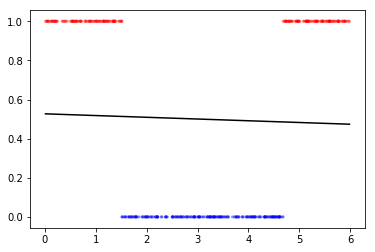

In [13]:
prob = tf.nn.sigmoid(y_lin).eval() # using the updated w,b -> predict prob
plt.scatter(x_train, y_train, s=5, alpha=0.3, color= color)
plt.plot(x_train, prob, c='k')
sess.close()

---

Let's add one hidden layer.

<img src = https://s3-us-west-2.amazonaws.com/nycdatasciecneipynb/first_hidden.png height=200 width = 300>
<br/>
Define the row vector 

$$w_1 = (\alpha^1, \alpha^2) \ \text{ and } \ b_1 = (\beta^1, \beta^2),$$

we may write the "formula" above with matrix notation:
<br/>
<img src = https://s3-us-west-2.amazonaws.com/nycdatasciecneipynb/first_hidden_2.png height=250 width = 375>
<br/>
Then we aggregate the two first layer prediction, to make a new one:
<br/>
<img src = https://s3-us-west-2.amazonaws.com/nycdatasciecneipynb/second_layer.png height=250 width = 375>

In [14]:
sess = tf.InteractiveSession()

x = tf.constant(x_train, dtype=tf.float32)
y = tf.constant(y_train, dtype=tf.float32)
w_1 = tf.Variable(tf.truncated_normal([1,2], stddev=0.1))
b_1 = tf.Variable(tf.constant(0.1, shape=[1,2]))
hidden = tf.nn.sigmoid(tf.add(tf.matmul(x, w_1), b_1))
w_2 = tf.Variable(tf.truncated_normal([2,1], stddev=0.1))
b_2 = tf.Variable(tf.constant(0.1, shape=[1,1]))

# y_lin = tf.add(tf.matmul(hidden, w_2), b_2)
# loss = -1*tf.reduce_mean(y_lin*y - tf.log(1+tf.exp(y_lin)), 0)

y_lin = tf.nn.sigmoid(tf.add(tf.matmul(hidden, w_2), b_2))
print(y_lin.shape)
print(y.shape)
loss = tf.reduce_mean(- (tf.multiply(y,tf.log(y_lin))) - (tf.multiply ( (1-y),tf.log( 1- y_lin) )))
train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

steps = 20000
tf.global_variables_initializer().run()
for i in range(steps):
    train_step.run()

(400, 1)
(400, 1)


The result becomes much better!

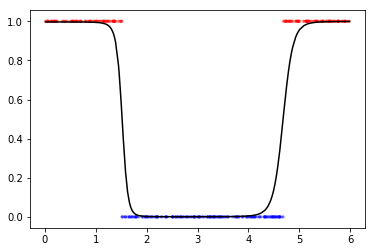

In [15]:
#prob = tf.nn.sigmoid(y_lin).eval()
prob = y_lin.eval()
plt.scatter(x_train, y_train, s=5, alpha=0.3, color= color)
plt.plot(x_train, prob, c='k')

#### More on `Forward Propogation` and `Backpropogation`

Now we know the math behind a simple neural network, but how was it related to the popular graph of neurons?

<img src = https://s3-us-west-2.amazonaws.com/nycdatasciecneipynb/neurons.png height=250 width = 375>

Our example can be represented by the plot below. The equations on the top show the forward propogation:

<img src = https://s3-us-west-2.amazonaws.com/nycdatasciecneipynb/neurons_ex_img/4.png height=400 width = 500>

- The loss function, $loss(w_1, b_1, w_2, b_2)$ can be constructed with the output $y=f \ ( \ f \ ( x \times w_1 + b_1) \times w_2 + b_2)$. 
- The loss function can be then minimized by **gradient descent**, which utilize the differential of the loss function.

Differentiating the loss function can be complicated. To show how error is passed through **backpropogation**, we instead differentiate the output $y$ with respect to $w_1, b_1, w_2$ and $b_2$.

$$
\frac{ \partial{y} }{ \partial{w_2}} = f'(p \cdot w_2 + b_2) \cdot p
$$

$$
\frac{ \partial{y} }{ \partial{b_2}} = f'(p \cdot w_2 + b_2) \cdot  \textbf{1}
$$

$$
\frac{ \partial{y} }{ \partial{w_1}} = f'(p \cdot w_2 + b_2) \cdot w_2 \cdot f'(x \cdot w_1 + b_1 ) \cdot x
$$

$$
\frac{ \partial{y} }{ \partial{w_1}} = f'(p \cdot w_2 + b_2) \cdot w_2 \cdot f'(x \cdot w_1 + b_1 ) \cdot \textbf{1}
$$

Below we visualize how the second layer uses the result from the first layer ($p^1$ and $p^2$).

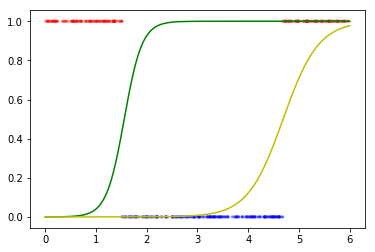

In [16]:
plt.scatter(x_train, y_train, s=5, alpha=0.3, color= color)
pts = np.linspace(0,6,800)
b = b_1.eval()
w = w_1.eval()

def sigmoid(x):
    x = tf.constant(x, dtype=tf.float32)
    result = tf.nn.sigmoid(x).eval()
    return result

curve1 = sigmoid(b[0,0] + w[0,0]*pts)
curve2 = sigmoid(b[0,1] + w[0,1]*pts)
plt.plot(pts, curve1,'g')
plt.plot(pts, curve2,'y')
sess.close()

It would be better to put everything together:

In [17]:
class One_layer_of_size_two(object):
    def __init__(self):
        self.__w1 = None
        self.__b1 = None
        self.__w2 = None
        self.__b1 = None
        
    def __initialize_model(self, x_train, y_train):
        x = tf.constant(x_train, dtype=tf.float32)
        y = tf.constant(y_train, dtype=tf.float32)
        w_1 = tf.Variable(tf.truncated_normal(shape = [1,2], stddev=0.1))
        b_1 = tf.Variable(tf.constant(0.1, shape=[1,2]))
        hidden = tf.nn.sigmoid(tf.add(tf.matmul(x, w_1), b_1))
        w_2 = tf.Variable(tf.truncated_normal([2,1], stddev=0.1))
        b_2 = tf.Variable(tf.constant(0.1, shape=[1,1]))
        y_lin = tf.add(tf.matmul(hidden, w_2), b_2)
        
        # Can use our manual formula or the inbuilt function
        #loss = -1*tf.reduce_mean(y_lin*y - tf.log(1+tf.exp(y_lin)), 0)
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_lin, labels=y))
        
        tf.global_variables_initializer().run()
        train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
        return train_step, w_1, b_1, w_2, b_2
        
    def fit(self, x_train, y_train, steps=20000):
        train_step, w_1, b_1, w_2, b_2 = self.__initialize_model(x_train, y_train)
        tf.global_variables_initializer().run()
        for i in range(steps):
            train_step.run()
            
        self.__w1 = w_1.eval()
        self.__b1 = b_1.eval()
        self.__w2 = w_2.eval()
        self.__b2 = b_2.eval()
    
    def __sigmoid(self, x):
        x = tf.constant(x, dtype=tf.float32)
        result = tf.nn.sigmoid(x).eval()
        return result
        
    def predict_prob(self, x_train):
        w1 = self.__w1
        b1 = self.__b1
        w2 = self.__w2
        b2 = self.__b2
        y_lin = np.dot(self.__sigmoid(np.dot(x_train, w1)+b1), w2)+b2
        return self.__sigmoid(y_lin)
    
    @property
    def w1(self):
        return self.__w1
    
    @property
    def b1(self):
        return self.__b1
    
    @property
    def w2(self):
        return self.__w2
    
    @property
    def b2(self):
        return self.__b2

Our goal is to be able to work as in `sklearn`:

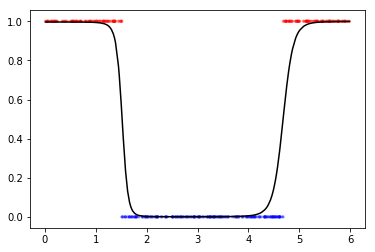

In [18]:
sess = tf.InteractiveSession()
nn = One_layer_of_size_two()
nn.fit(x_train, y_train)
prob = nn.predict_prob(x_train)
plt.scatter(x_train, y_train, s=5, alpha=0.3, color= color)
plt.plot(x_train, prob, c='k')

### Keep in mind that there is a session that we need to close
sess.close()

**Exercise**: Implement random initialization to the class.

---


### The MNIST dataset:

We need to make the code more general, so it's flexible with 
- amount of observations
- amount of features
- amount of labels

**Note:** Below we no longer implement `predict_prob`, instead we implement `predict`.

In [45]:
images = mnist.train.images
labels = mnist.train.labels

In [20]:
class One_layer(object):
    def __init__(self, size_hidden=2):
        self.__w1 = None
        self.__b1 = None
        self.__w2 = None
        self.__b1 = None
        self.__size_hidden = size_hidden
        
    def __initialize_model(self, x_train, y_train):
        num_observations= x_train.shape[0]
        num_features   = x_train.shape[1]
        num_labels     = y_train.shape[1]
        size_hidden    = self.__size_hidden
        
        x = tf.constant(x_train, dtype=tf.float32)
        y = tf.constant(y_train, dtype=tf.float32)
        w_1 = tf.Variable(tf.truncated_normal([num_features, size_hidden], stddev=0.1))
        b_1 = tf.Variable(tf.constant(0.1, shape=[1, size_hidden]))
        hidden = tf.nn.sigmoid(tf.add(tf.matmul(x, w_1), b_1))
        w_2 = tf.Variable(tf.truncated_normal([size_hidden, num_labels], stddev=0.1))
        b_2 = tf.Variable(tf.constant(0.1, shape=[1,num_labels]))
        y_lin = tf.add(tf.matmul(hidden, w_2), b_2)
        
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_lin, labels=y))
        
        #tf.global_variables_initializer().run()
        train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
        return train_step, w_1, b_1, w_2, b_2
        
    def fit(self, x_train, y_train, steps=20000):
        train_step, w_1, b_1, w_2, b_2 = self.__initialize_model(x_train, y_train)
        tf.global_variables_initializer().run()
        for i in range(steps):
            train_step.run()
            
        self.__w1 = w_1.eval()
        self.__b1 = b_1.eval()
        self.__w2 = w_2.eval()
        self.__b2 = b_2.eval()
    
    def __sigmoid(self, x):
        x = tf.constant(x, dtype=tf.float32)
        result = tf.nn.sigmoid(x).eval()
        return result
        
    def predict(self, x_train):
        w1 = self.__w1
        b1 = self.__b1
        w2 = self.__w2
        b2 = self.__b2
        y_lin = np.dot(self.__sigmoid(np.dot(x_train, w1)+b1), w2)+b2
        return tf.argmax(self.__sigmoid(y_lin), 1).eval()
        
    
    @property
    def w1(self):
        return self.__w1
    
    @property
    def b1(self):
        return self.__b1
    
    @property
    def w2(self):
        return self.__w2
    
    @property
    def b2(self):
        return self.__b2

In [21]:
start = time.time()
sess = tf.InteractiveSession()
nn = One_layer(size_hidden=10)
nn.fit(images, labels, steps=200)
predict = nn.predict(images)
print('Accuracy: ', np.mean(predict == np.argmax(labels, 1)))
print('Time elapsed: ', time.time() - start)
sess.close()

/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Accuracy:  0.5301272727272728
Time elapsed:  42.56711411476135


We saw the accuracy is less than 60%. One thing we might want to do is to increase the steps, but it is likely to be very slow. Below we introduce the concept of batch, where we need another TensorFlow type: **`placeholder`**.

In [48]:
class One_layer_batch(object):
    def __init__(self, size_hidden=2):
        self.__w1 = None
        self.__b1 = None
        self.__w2 = None
        self.__b1 = None
        self.__size_hidden = size_hidden
        
    def __initialize_model(self, x_train, y_train):
        num_observations= x_train.shape[0]
        num_features   = x_train.shape[1]
        num_labels     = y_train.shape[1]
        size_hidden    = self.__size_hidden
        
        x = tf.placeholder(tf.float32, shape=[None, num_features])
        y = tf.placeholder(tf.float32, shape=[None, num_labels])
        w_1 = tf.Variable(tf.truncated_normal([num_features, size_hidden], stddev=0.1))
        b_1 = tf.Variable(tf.constant(0.1, shape=[1, size_hidden]))
        hidden = tf.nn.sigmoid(tf.add(tf.matmul(x, w_1), b_1))
        w_2 = tf.Variable(tf.truncated_normal([size_hidden, num_labels], stddev=0.1))
        b_2 = tf.Variable(tf.constant(0.1, shape=[1,num_labels]))
        y_lin = tf.add(tf.matmul(hidden, w_2), b_2)
        
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_lin, labels=y))
        train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cross_entropy)
        return train_step, x, y, w_1, b_1, w_2, b_2
        
    def fit(self, x_train, y_train, batch_size = 100, increment = 20, steps = 10000):
        train_step, x, y, w_1, b_1, w_2, b_2 = self.__initialize_model(x_train, y_train)
        
        num_observations = x_train.shape[0]
        tf.global_variables_initializer().run()
        for i in range(steps):
            start_ = (i*20) % num_observations
            end_   = min(num_observations, start_ + batch_size)
            x_batch = x_train[start_:end_,:]
            y_batch = y_train[start_:end_,:]
            train_step.run(feed_dict={x: x_batch, y: y_batch})

            
        self.__w1 = w_1.eval()
        self.__b1 = b_1.eval()
        self.__w2 = w_2.eval()
        self.__b2 = b_2.eval()
    
    def __sigmoid(self, x):
        x = tf.constant(x, dtype=tf.float32)
        result = tf.nn.sigmoid(x).eval()
        return result
        
    def predict(self, x_train):
        w1 = self.__w1
        b1 = self.__b1
        w2 = self.__w2
        b2 = self.__b2
        y_lin = np.dot(self.__sigmoid(np.dot(x_train, w1)+b1), w2)+b2
        return tf.argmax(self.__sigmoid(y_lin), 1).eval()
        
    
    @property
    def w1(self):
        return self.__w1
    
    @property
    def b1(self):
        return self.__b1
    
    @property
    def w2(self):
        return self.__w2
    
    @property
    def b2(self):
        return self.__b2

In [49]:
start = time.time()
sess = tf.InteractiveSession()
nn = One_layer_batch(size_hidden=40)
nn.fit(images, labels, batch_size = 100, increment = 20, steps = 3000)
predict = nn.predict(images)
print ('Training Accuracy: ', np.mean(predict == np.argmax(labels, 1)))
predict = nn.predict(mnist.validation.images)
print('Validation Accuracy: ', np.mean(predict == np.argmax(mnist.validation.labels, 1)))
predict = nn.predict(mnist.test.images)
print('Test Accuracy: ', np.mean(predict == np.argmax(mnist.test.labels, 1)))
print('Time elapsed: ', time.time()-start)
sess.close()

/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Training Accuracy:  0.9107090909090909
Validation Accuracy:  0.9208
Test Accuracy:  0.9155
Time elapsed:  8.716952085494995


In [50]:
start = time.time()
sess = tf.InteractiveSession()
nn = One_layer_batch(size_hidden=100)
nn.fit(images, labels, batch_size = 100, increment = 20, steps = 30000)
predict = nn.predict(images)
print('Training Accuracy: ', np.mean(predict == np.argmax(labels, 1)))
predict = nn.predict(mnist.validation.images)
print('Validation Accuracy: ', np.mean(predict == np.argmax(mnist.validation.labels, 1)))
predict = nn.predict(mnist.test.images)
print('Test Accuracy: ', np.mean(predict == np.argmax(mnist.test.labels, 1)))
print('Time elapsed: ', time.time()-start)
sess.close()

/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Training Accuracy:  0.9747454545454546
Validation Accuracy:  0.9694
Test Accuracy:  0.9667
Time elapsed:  49.82860279083252


In [77]:
start = time.time()
sess = tf.InteractiveSession()
nn = One_layer_batch(size_hidden=300)
nn.fit(images, labels, batch_size = 800, increment = 20, steps = 30000)
predict = nn.predict(images)
print('Training Accuracy: ', np.mean(predict == np.argmax(labels, 1)))
predict = nn.predict(mnist.validation.images)
print('Validation Accuracy: ', np.mean(predict == np.argmax(mnist.validation.labels, 1)))
predict = nn.predict(mnist.test.images)
print('Test Accuracy: ', np.mean(predict == np.argmax(mnist.test.labels, 1)))
print('Time elapsed: ', time.time()-start)
sess.close()

/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Training Accuracy:  0.9752909090909091
Validation Accuracy:  0.9706
Test Accuracy:  0.9692
Time elapsed:  640.3244161605835


**Exercise** How would you tune this model?

### Keras

In [51]:
from keras.models import Sequential
from keras.metrics import categorical_accuracy
from keras.layers import Dense, Activation
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(40, input_dim=784)) # number of hidden neurons = 40
model.add(Activation('sigmoid'))
model.add(Dense(10))
model.add(Activation('softmax'))


sgd = SGD(lr=0.1) # Stochastic Gradient Descent with learning rate = 0.1
model.compile(
    loss='categorical_crossentropy',
    optimizer=sgd,
    metrics=[categorical_accuracy]
)

start = time.time()
model.fit(images, labels, epochs=20, batch_size=10)

print("\nTime elasped: {} seconds\n".format(time.time() - start))

score = model.evaluate(
    mnist.validation.images, 
    mnist.validation.labels
)

print(score)

Using TensorFlow backend.


Epoch 1/20
55000/55000 [==============================] - 7s 127us/step - loss: 0.3951 - categorical_accuracy: 0.89200s - loss: 0.4060 - categorical_
Epoch 2/20
55000/55000 [==============================] - 5s 83us/step - loss: 0.2105 - categorical_accuracy: 0.9395
Epoch 3/20
55000/55000 [==============================] - 5s 84us/step - loss: 0.1665 - categorical_accuracy: 0.9521
Epoch 4/20
55000/55000 [==============================] - 5s 90us/step - loss: 0.1404 - categorical_accuracy: 0.9594
Epoch 5/20
55000/55000 [==============================] - 5s 85us/step - loss: 0.1228 - categorical_accuracy: 0.9649 3s - loss: 0.1305 - categorical_ - ETA: 3s - l - ETA: 0s - loss: 0.1241 - 
Epoch 6/20
55000/55000 [==============================] - 5s 87us/step - loss: 0.1103 - categorical_accuracy: 0.9687
Epoch 7/20
55000/55000 [==============================] - 5s 89us/step - loss: 0.1005 - categorical_accuracy: 0.9711 0s - loss: 0.1007 - ca
Epoch 8/20
55000/55000 [==========================

### Convolutional Neural Network

Convolution neural network take the two dimensional structure of images into account. Variables from layer to layer are no longer fully connected.

In [106]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W): # moving the kernel around on the image - 
    # on each step, get one value by matrix multiplication of the image and kernel
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME') # choose a padding such that output image size is 
                                                                    # equal to input
    
def max_pool_2x2(x): # Pooling after convolution to reduce the resultant image size 
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                              strides=[1, 2, 2, 1], padding='SAME')
    #after pooling returned matrix size will be reduced by half 14x14x32 - because we are using stride 2, 
    # so we are skipping alternate cells
    
        
        
#### From here!!!

# Convolution requires a 4 dimensional tensor
start = time.time()
sess = tf.InteractiveSession()
x = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.float32, shape=[None, 10])


W_conv1 = weight_variable([5, 5, 1, 32]) # Each image size is 28x28x1, so use n=32 filters of 5x5x1 size
b_conv1 = bias_variable([32])
x_train = tf.reshape(x, [-1,28,28,1]) # [batch size, height, width, color_channels]
# -1 is indicating that particular dimension should be sized so that the total number of elements remains constant. 
h_conv1 = tf.nn.relu(conv2d(x_train, W_conv1) + b_conv1)
print(h_conv1.shape)
h_pool1 = max_pool_2x2(h_conv1)
print(h_pool1.shape)

# after pooling, 14x14x32 will be considered as one image on which the next convolution will apply
# initialize a new window of size 5x5x32 to match the results from the prev step
W_conv2 = weight_variable([5, 5, 32, 64]) # 64 such windows
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)
print(h_pool2.shape)

# After h_pool2, image size is [7,7,64]. Choosing 1024 neurons for the fully-connected (fc) layer 
# W_fc1 is the 2-D weight matrix between the last convolution layer and the next dense layer  
W_fc1 = weight_variable([7* 7* 64, 1024]) 
b_fc1 = bias_variable([1024])

# We flatten h_pool2 and input it as a 1-D vector into 1024 neurons in the hidden layer
# making the dense layer -  unroll into a single 1D vector
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Next dense layer is the output layer consisting of 10 neurons
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.matmul(h_fc1, W_fc2) + b_fc2
        
        
sess = tf.InteractiveSession()       
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())
for i in range(20001):
    batch = mnist.train.next_batch(50)
    if i%500 == 0:
        print("step %d, time elasped %.3f"% (i, time.time()-start))
    train_step.run(feed_dict={x: batch[0], y: batch[1]})

print("validation accuracy %g"%accuracy.eval(feed_dict={x: mnist.validation.images, y: mnist.validation.labels}))
print("test accuracy %g"%accuracy.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels}))

/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


(?, 28, 28, 32)
(?, 14, 14, 32)
(?, 7, 7, 64)
step 0, time elasped 3.190
step 500, time elasped 53.301
step 1000, time elasped 103.977
step 1500, time elasped 154.057
step 2000, time elasped 201.485
step 2500, time elasped 253.241
step 3000, time elasped 303.754
step 3500, time elasped 353.270
step 4000, time elasped 407.352
step 4500, time elasped 460.063
step 5000, time elasped 510.773
step 5500, time elasped 562.044
step 6000, time elasped 613.897
step 6500, time elasped 666.030
step 7000, time elasped 718.717
step 7500, time elasped 771.416
step 8000, time elasped 825.049
step 8500, time elasped 878.923
step 9000, time elasped 933.397
step 9500, time elasped 988.370
step 10000, time elasped 1043.713
step 10500, time elasped 1099.479
step 11000, time elasped 1155.939
step 11500, time elasped 1212.532
step 12000, time elasped 1269.443
step 12500, time elasped 1326.853
step 13000, time elasped 1384.368
step 13500, time elasped 1442.347
step 14000, time elasped 1500.484
step 14500, tim

In [ ]:
sess.close()

### Dropout

Here, we train multiple different models: <br>
M1: considers only a random subset of features <br>
M2: considers only another random subset of features.. and so on..
<br> 
- The idea is to train models with randomly selected subset of the variables:

<img src = https://s3-us-west-2.amazonaws.com/nycdatasciecneipynb/neurons_ex_img/dropout1.png height=300 width = 750>

<br>
But can we do better?

- Instead of train multiple models with different network, we can randomly select variables in each step of gradient descent: 
Using a single model, we randomly activate only a subset of neurons

<img src = https://s3-us-west-2.amazonaws.com/nycdatasciecneipynb/neurons_ex_img/dropout2.png height=300 width = 750>


- All the variables are used for predicting. They need to be scaled to predict properly.

In [136]:
#### From here!!!
start = time.time()
sess = tf.InteractiveSession()
x = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.float32, shape=[None, 10])

W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
x_train = tf.reshape(x, [-1,28,28,1])
h_conv1 = tf.nn.relu(conv2d(x_train, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# In the fully connected layer 1, activate only a subset of neurons in each iteration
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
        
        
sess = tf.InteractiveSession()       
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())
for i in range(20001):
    batch = mnist.train.next_batch(50)
    if i%500 == 0:
        print("step %d, time elasped %.3f"% (i, time.time()-start))
    train_step.run(feed_dict={x: batch[0], y: batch[1], keep_prob: 0.5})

print("validation accuracy %g"%accuracy.eval(feed_dict={x: mnist.validation.images, y: mnist.validation.labels, keep_prob: 1.}))
print("test accuracy %g"%accuracy.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels, keep_prob: 1.}))
sess.close()

/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


step 0, time elasped 11.381
step 500, time elasped 64.419
step 1000, time elasped 116.676
step 1500, time elasped 171.139
step 2000, time elasped 224.021
step 2500, time elasped 278.082
step 3000, time elasped 336.270
step 3500, time elasped 391.206
step 4000, time elasped 446.368
step 4500, time elasped 501.111
step 5000, time elasped 556.236
step 5500, time elasped 611.375
step 6000, time elasped 666.417
step 6500, time elasped 721.709
step 7000, time elasped 776.514
step 7500, time elasped 831.522
step 8000, time elasped 886.152
step 8500, time elasped 941.015
step 9000, time elasped 995.518
step 9500, time elasped 1050.317
step 10000, time elasped 1104.637
step 10500, time elasped 1159.152
step 11000, time elasped 1213.278
step 11500, time elasped 1267.357
step 12000, time elasped 1321.698
step 12500, time elasped 1375.750
step 13000, time elasped 1429.839
step 13500, time elasped 1483.748
step 14000, time elasped 1537.524
step 14500, time elasped 1590.753
step 15000, time elasped 